## This version does the ZOGY but computes the kernels in fourier space, and then convolves images in real space.

Do it with new testing object.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

Use the code from `diffimTests.py`.

In [68]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., varSourceChange=1500., 
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0, 0]
PSF y spatial-variation: 0.0 0.0
Variable source: 37 245.899250131 279.361590046 1423.89964966 2923.89964966
(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16735074378053241, 17.213851327082029, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16735074378062, 17.213851327082025, 218.0, 1469.0572762553779)


In [69]:
res = testObj.doALInStack(doPreConv=False, doDecorr=True)
D_AL = res.decorrelatedDiffim.getMaskedImage().getImage().getArray()
D_AL[0,:] = D_AL[:,0] = D_AL[-1,:] = D_AL[:,-1] = 0.
D_AL[np.isnan(D_AL) | np.isinf(D_AL)] = 0.
print dit.computeClippedImageStats(D_AL)
D_ZOGY = testObj.doZOGY()
D_ZOGY.im[D_AL == 0.] = 0.
print dit.computeClippedImageStats(D_ZOGY.im)
S_ZOGY = testObj.S_corr_ZOGY
S_ZOGY.im[D_AL == 0.] = 0.
print dit.computeClippedImageStats(S_ZOGY.im)

(-0.0015253188, 0.85330766, -4.7341137, 7.5547566)
(-0.0020530236655429556, 0.85536452366657933, -4.8672571323326945, 4.2443087540407634)
(0.017413368910657177, 0.85086822133521312, -4.5278728182815851, 9.1269917837247458)


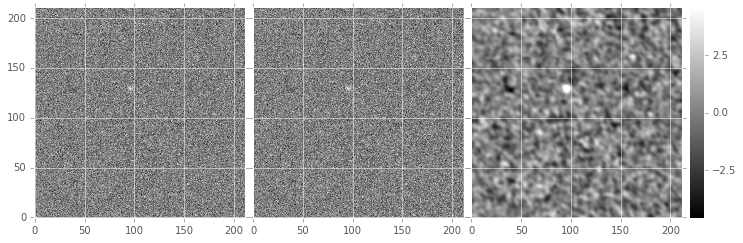

In [70]:
fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
dit.plotImageGrid((D_AL[x1d:x2d,y1d:y2d], D_ZOGY.im[x1d:x2d,y1d:y2d], S_ZOGY.im[x1d:x2d,y1d:y2d]))

In [82]:
reload(dit)
import pandas as pd

# update: need to set mask on edge values. They're zero so they're setting the stdev of the image too low.
src_AL = dit.doDetection(res.decorrelatedDiffim)
src_ZOGY = dit.doDetection(D_ZOGY.asAfwExposure())
src_SZOGY = dit.doDetection(S_ZOGY.asAfwExposure(), doSmooth=False)

df = pd.DataFrame({col: src_AL.columns[col] for col in src_AL.schema.getNames()})
print df.base_NaiveCentroid_x.values, '\n', df.base_NaiveCentroid_y.values, '\n', \
    df.base_PeakLikelihoodFlux_flux.values, '\n', df.base_PsfFlux_flag.values, '\n', \
    df.base_PsfFlux_flag_edge.values, '\n'
df = pd.DataFrame({col: src_ZOGY.columns[col] for col in src_ZOGY.schema.getNames()})
print df.base_NaiveCentroid_x.values, '\n', df.base_NaiveCentroid_y.values, '\n', \
    df.base_PeakLikelihoodFlux_flux.values, '\n', df.base_PsfFlux_flag.values, '\n', \
    df.base_PsfFlux_flag_edge.values, '\n'
df = pd.DataFrame({col: src_SZOGY.columns[col] for col in src_SZOGY.schema.getNames()})
print df.base_NaiveCentroid_x.values, '\n', df.base_NaiveCentroid_y.values, '\n', \
    df.base_PeakLikelihoodFlux_flux.values, '\n', df.base_PsfFlux_flag.values, '\n', \
    df.base_PsfFlux_flag_edge.values, '\n'

[ 415.12979616  245.30795189] 
[  35.0533209   278.27599122] 
[ 382.09007005  190.63905958] 
[ True False] 
[False False] 

[ 189.48166002  245.2977583   465.80851736  382.78138146] 
[ 275.98250917  278.27272629  317.76650571  336.8171178 ] 
[   8.43271084  165.37804473  151.41992248   89.77542331] 
[False False False False] 
[False False False False] 

[ 188.05906891  246.00500017  383.09533608  465.0944471   383.04921252] 
[ 277.11145177  279.00892644  288.07933351  318.05045774  336.09154442] 
[-195.08779748  391.35131404  185.17362961  212.54369933  195.27438743] 
[False False False False False] 
[False False False False False] 



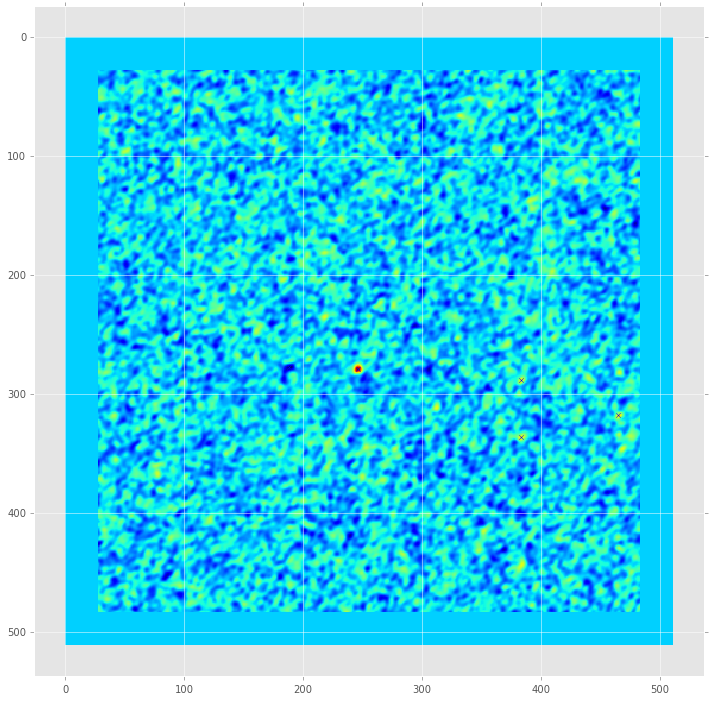

In [87]:
df = pd.DataFrame({col: src_SZOGY.columns[col] for col in src_SZOGY.schema.getNames()})
fig = plt.figure(1, (12, 12))
plt.imshow(S_ZOGY.im, interpolation='none')
plt.scatter(df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, marker='x')